# STIRAP in a 3-level system
STIRAP (STImulated Raman Adiabatic Passage, see e.g. [Shore1998](https://journals.aps.org/rmp/pdf/10.1103/RevModPhys.70.1003)) is a method for adiabatically transferring the population of a quantum system from one state to another by using two drive fields coupled to an intermediate state without actually ever populating the intermediate state. The benefits over e.g. two Rabi pulses, are that since STIRAP is an adiabatic process, it is relatively easy (I've been told) to make it highly efficient. The other key benefit is that the intermediate state can be an unstable state, yet there is no population loss since it is never populated.

This notebook sets up a 3-level system and relevant couplings using the `toy_models` package and then time evolves the system using `QuTiP` to simulate STIRAP. I'll be following the definitions of Shore1998 as best as I can. The level diagram from the paper is shown below.

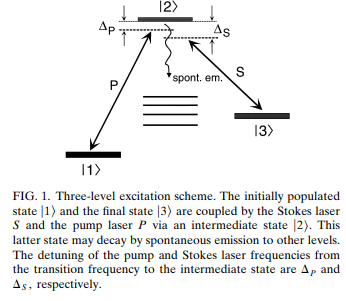
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

## Set up states and basis
We start by defining the three states of the system: we'll have two ground states (i.e. states that don't decay) $|1\rangle$ and $|3\rangle$, and one excited state $|2\rangle$, which we will later set to have a decay to an additional state $|4\rangle$ representing all decays out of the system:

In [2]:
# Define states
s1 = BasisState(qn=ToyQuantumNumbers(label="1"))
s2 = BasisState(qn=ToyQuantumNumbers(label="2"))
s3 = BasisState(qn=ToyQuantumNumbers(label="3"))
s4 = BasisState(qn=ToyQuantumNumbers(label="4")) # A target state for decays from |2>

# Define basis
basis = Basis((s1, s2, s3, s4))
basis.print_basis()

|0> = |1>
|1> = |2>
|2> = |3>
|3> = |4>


## Define energies, couplings and decays
I'm going to define the system in the rotating frame as given in [Shore1998](https://journals.aps.org/rmp/pdf/10.1103/RevModPhys.70.1003) so that the Hamiltonian doesn't have any quickly rotating terms of the form $e^{i\omega t}$.

The Hamiltonian I'm trying to produce is shown below (with $\hbar = 1$): 

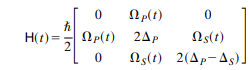

### Energies

In [3]:
Δp = Symbol('Delta_p') # Detuning for pump beam
Δs = Symbol('Delta_s') # Detuning for Stokes beam
E1 = ToyEnergy(s1, 0)
E2 = ToyEnergy(s2, Δp)

# The energy for state |3> needs to be defined in two parts since it contains two sympy.Symbols
E3p = ToyEnergy(s3, Δp)
E3s = ToyEnergy(s3, -Δs)

### Couplings

In [4]:
Ωp = Symbol('Omega_p') # Drive field Rabi rate for pump beam
Ωs = Symbol('Omega_s') # Drive field Rabi rate for Stokes beam

coupling_p = ToyCoupling(s1,s2,Ωp/2, time_dep = "exp(-(t+t_p)**2/(2*sigma_p**2))", time_args= {"t_p":-1, "sigma_p":1})
coupling_s = ToyCoupling(s2,s3,Ωs/2, time_dep = "exp(-(t+t_s)**2/(2*sigma_s**2))", time_args= {"t_s":1, "sigma_s":1})

### Decays
Defining a decay from $|2\rangle$ to $|4\rangle$ :

In [5]:
decay = ToyDecay(s2, ground = s4, gamma = Symbol("Gamma"))

### Define a QuantumSystem
The QuantumSystem object combines the basis, Hamiltonian and decays to make setting parameters for time evolution using QuTiP more convenient.

In [6]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E1, E2, E3p, E3s, coupling_p, coupling_s],
    decays=[decay],
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

## Time-evolution using `QuTiP`
We can now see if time evolving the system results in something resembling STIRAP. The key to success is to choose the parameters well. Shore gives us the rule of thumb that we should have $\sqrt{\Omega_p^2 + \Omega_s^2}\tau > 10$ where $\tau$ is proportional to the time overlap of the Stokes and pump pulse. In practice it seems that taking the centers of the Gaussians to be separated by $2\sigma$ works pretty well. The broader the Gaussians are (i.e. larger $\sigma$), the more adiabatic the process, which results in less population in the intermediate state and therefore less loss. I'm taking both pulses to have the same parameters for simplicity (except they occur at different times of course).

In [7]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'Delta_p': 1, 'Delta_s': 1, 't_p': -1, 'sigma_p': 1, 'Omega_p': 1, 't_s': 1, 'sigma_s': 1, 'Omega_s': 1, 'Gamma': 1}


In [11]:
# Generate a Qobj representing the initial state
psi0 = (1*s1).qobj(basis)

# Make operators for getting the probability of being in each state
P_1_op = qutip.Qobj((1*s1).density_matrix(basis), type = "oper")
P_2_op = qutip.Qobj((1*s2).density_matrix(basis), type = "oper")
P_3_op = qutip.Qobj((1*s3).density_matrix(basis), type = "oper")
P_4_op = qutip.Qobj((1*s4).density_matrix(basis), type = "oper")


# Set the parameters for the system

# Good STIRAP
Omega = 10
t0 = 10
sigma = 10
Delta = 0

# Bad STIRAP
# Omega = 5
# t0 = 1
# sigma = 1
# Delta = 0

args["Delta_p"] = Delta
args["Omega_p"] = Omega
args["sigma_p"] = sigma
args["t_p"] = -t0

args["Delta_s"] = Delta
args["Omega_s"] = Omega
args["sigma_s"] = sigma
args["t_s"] = t0

# Times at which result is requested
times = np.linspace(-5*sigma,5*sigma,1001)

# Setting the max_step is sometimes necessary
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = [P_1_op, P_2_op, P_3_op, P_4_op],
                      progress_bar=pb, options = options)

 Total run time:   0.55s*] Elapsed 0.55s / Remaining 00:00:00:00[*********68%****       ] Elapsed 0.33s / Remaining 00:00:00:00


Transfer efficiency: 99.5 %


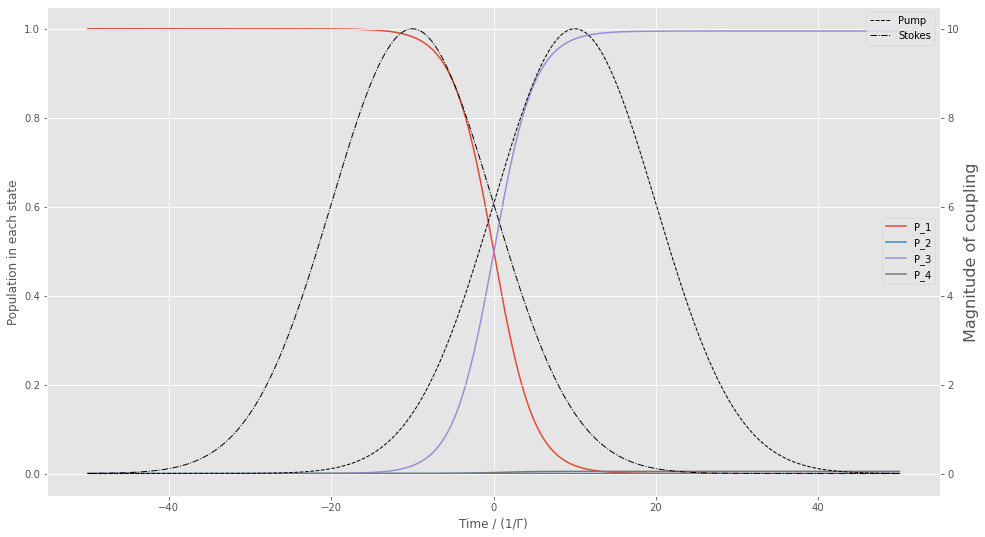

In [12]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_1")
ax.plot(times, result.expect[1], label = "P_2")
ax.plot(times, result.expect[2], label = "P_3")
ax.plot(times, result.expect[3], label = "P_4")
ax.legend()
ax.set_xlabel("Time / (1/Γ)")
ax.set_ylabel("Population in each state")

axc = ax.twinx()
coupling_p.plot_time_dep(times, args, ax=axc, ls = '--', c = 'k', lw = 1, label = 'Pump')
coupling_s.plot_time_dep(times, args, ax=axc, ls = '-.', c = 'k', lw = 1, label = 'Stokes')
axc.legend()



print(f"Transfer efficiency: {result.expect[2][-1]*100:.1f} %")